In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import Table

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE


from scipy.stats import zscore
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_excel('Dataset.xlsx')

## Clean Data

In [3]:
# Get the list of columns to convert to categorical
categorical_columns = df.select_dtypes(include='int64').columns.tolist()

# Convert the selected columns to categorical
df[categorical_columns] = df[categorical_columns].astype('category')

numeric_data = df.select_dtypes(include=[np.number])

# Calculate MAD for each column
mad = numeric_data.mad()

# Choose a threshold multiplier
k = 3

# Calculate the threshold value
threshold = k * mad

# Identify outliers
outliers = (np.abs(numeric_data - numeric_data.median()) > threshold)

# Apply logarithm to the specified columns
outlier_columns = ['CommissionSacrificePercentage', 'BonusCommissionPercentage']
for column in outlier_columns:
    df[column] = np.log1p(df[column])

numeric_data = df.select_dtypes(include=[np.number])

## Feature Engineering

### Categorical Encoding - Label Encoding

In [4]:
# Convert categorical columns to strings
df['WorkflowStatus'] = df['WorkflowStatus'].astype(str)
df['UWDecision'] = df['UWDecision'].astype(str)

df['Product'] = df['Product'].astype(str)
df['ProductGroup'] = df['ProductGroup'].astype(str)
df['ProductType'] = df['ProductType'].astype(str)

df['CommissionSacrificeType'] = df['CommissionSacrificeType'].astype(str)
df['RenewalSacrificeType'] = df['RenewalSacrificeType'].astype(str)

df['CommDateProvided'] = df['CommDateProvided'].astype(str)
df['FreeCover'] = df['FreeCover'].astype(str)

# Combined Features
df['Combined_Status1'] = df['WorkflowStatus'] + '_' + df['UWDecision']
df['Combined_Status2'] = df['Product'] + '_' + df['ProductGroup'] + '_' + df['ProductType']
df['Combined_Status3'] = df['CommissionSacrificeType'] + '_' + df['RenewalSacrificeType']
df['Combined_Status4'] = df['CommDateProvided'] + '_' + df['FreeCover']

# Initialise LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the combined status
df['WorkflowStatus_UWDecision'] = label_encoder.fit_transform(df['Combined_Status1'])
df['Product_ProductGroup_ProductType'] = label_encoder.fit_transform(df['Combined_Status2'])
df['CommissionSacrificeType_RenewalSacrificeType'] = label_encoder.fit_transform(df['Combined_Status3'])
df['CommDateProvided_FreeCover'] = label_encoder.fit_transform(df['Combined_Status4'])


# Drop unnecessary columns
df.drop(['WorkflowStatus', 'UWDecision', 'Combined_Status1'], axis=1, inplace=True)
df.drop(['Product', 'ProductGroup', 'ProductType', 'Combined_Status2'], axis=1, inplace=True)
df.drop(['CommissionSacrificeType', 'RenewalSacrificeType', 'Combined_Status3'], axis=1, inplace=True)
df.drop(['CommDateProvided', 'FreeCover', 'Combined_Status4'], axis=1, inplace=True)

categorical_columns = df.select_dtypes(include='int32').columns.tolist()
df[categorical_columns] = df[categorical_columns].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157263 entries, 0 to 157262
Data columns (total 18 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Agency                                        157263 non-null  category      
 1   Indexation                                    157263 non-null  category      
 2   NoOfLives                                     157263 non-null  category      
 3   PropDate                                      157263 non-null  datetime64[ns]
 4   PaymentFreq                                   157263 non-null  category      
 5   ComissionSacrifice                            157263 non-null  category      
 6   CommissionSacrificePercentage                 157263 non-null  float64       
 7   CommissionTerms                               157263 non-null  category      
 8   Discount                                      157263 n

In [5]:
# Define different test sizes and n estimator values to test
test_sizes = [0.2, 0.25, 0.3, 0.33]
n_estimators_values = [50, 100, 150, 200]
n_values = [4,5,6,7]

In [6]:
# Create empty lists to store results
results = []
feature_importances_dict = {}

### Random Forest Feature Importance Scoring

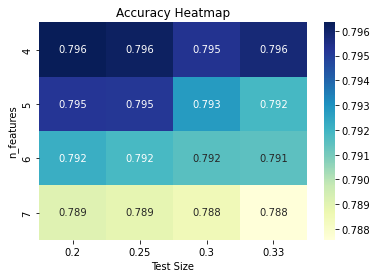

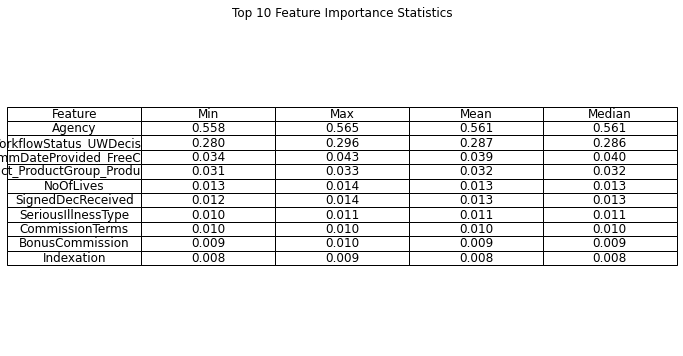

In [7]:
# Define features and target variable
features = ['Product_ProductGroup_ProductType', 'Agency', 'Indexation', 'NoOfLives',
            'CommDateProvided_FreeCover', 'PaymentFreq', 'ComissionSacrifice', 'CommissionSacrificeType_RenewalSacrificeType'
            , 'CommissionTerms', 'Discount', 'BonusCommission', 
            'SeriousIllnessType', 'SignedDecReceived', 'WorkflowStatus_UWDecision']
target = 'PolicyIssued'

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a Random Forest classifier with the current n estimator value
        rf_classifier = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(rf_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in dictionary for visualization
        feature_importances_dict[(test_size, n_estimators_value)] = feature_importances

        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            rf_classifier_selected = RandomForestClassifier(n_estimators=n_estimators_value, random_state=42)
            rf_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = rf_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            results.append((test_size, n_estimators_value, n, accuracy))
            
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

feature_importance_stats = {}
for feature in features:
    feature_importance_stats[feature] = {
        'Min': min(importance[feature] for importance in feature_importances_dict.values()),
        'Max': max(importance[feature] for importance in feature_importances_dict.values()),
        'Mean': sum(importance[feature] for importance in feature_importances_dict.values()) / len(feature_importances_dict),
        'Median': pd.Series([importance[feature] for importance in feature_importances_dict.values()]).median()
    }
    
# Create a DataFrame from feature importance statistics
feature_importance_stats_df = pd.DataFrame(feature_importance_stats).T

# Sort features by Mean importance and select top 10
top_10_features = feature_importance_stats_df.sort_values(by='Mean', ascending=False).head(10)

# Define statistics and colors
statistics = ['Min', 'Max', 'Mean', 'Median']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a table of feature importance statistics
table_data = []
for feature, row in top_10_features.iterrows():
    row_values = [f"{row[stat]:.3f}" for stat in statistics]
    table_data.append([feature] + row_values)

table = ax.table(cellText=table_data, colLabels=['Feature'] + statistics, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax.axis('off')

ax.set_title('Top 10 Feature Importance Statistics')

plt.show()

#### Gradient Boosting Feature Importance Scoring

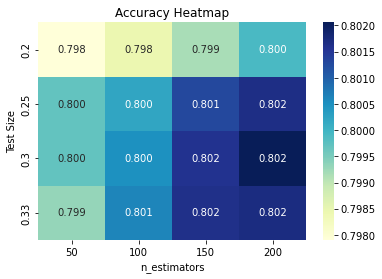

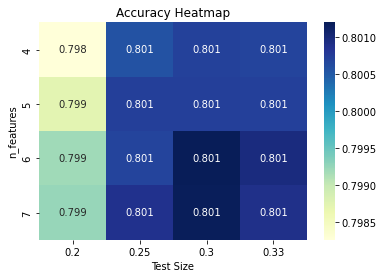

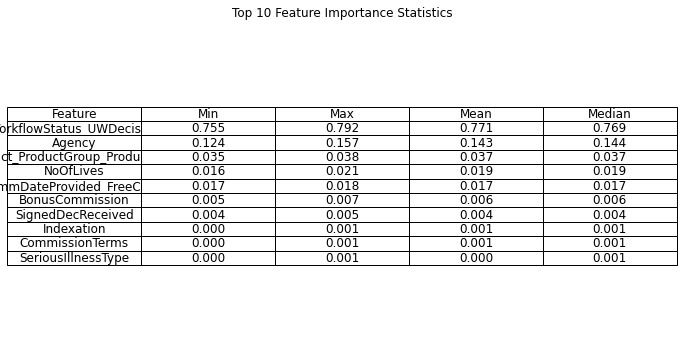

In [8]:
# Create empty lists to store results
results = []
feature_importances_dict = {}

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a Gradient Boosting classifier
        gb_classifier = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
        gb_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(gb_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in dictionary for visualization
        feature_importances_dict[(test_size, n_estimators_value)] = feature_importances
        
        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            gb_classifier_selected = GradientBoostingClassifier(n_estimators=n_estimators_value, random_state=42)
            gb_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = gb_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            results.append((test_size, n_estimators_value, n, accuracy))
            
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

feature_importance_stats = {}
for feature in features:
    feature_importance_stats[feature] = {
        'Min': min(importance[feature] for importance in feature_importances_dict.values()),
        'Max': max(importance[feature] for importance in feature_importances_dict.values()),
        'Mean': sum(importance[feature] for importance in feature_importances_dict.values()) / len(feature_importances_dict),
        'Median': pd.Series([importance[feature] for importance in feature_importances_dict.values()]).median()
    }
    
# Create a DataFrame from feature importance statistics
feature_importance_stats_df = pd.DataFrame(feature_importance_stats).T

# Sort features by Mean importance and select top 10
top_10_features = feature_importance_stats_df.sort_values(by='Mean', ascending=False).head(10)

# Define statistics and colors
statistics = ['Min', 'Max', 'Mean', 'Median']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a table of feature importance statistics
table_data = []
for feature, row in top_10_features.iterrows():
    row_values = [f"{row[stat]:.3f}" for stat in statistics]
    table_data.append([feature] + row_values)

table = ax.table(cellText=table_data, colLabels=['Feature'] + statistics, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax.axis('off')


ax.set_title('Top 10 Feature Importance Statistics')

plt.show()

### LightGBM Feature Importance Scoring

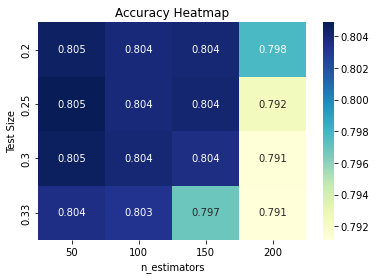

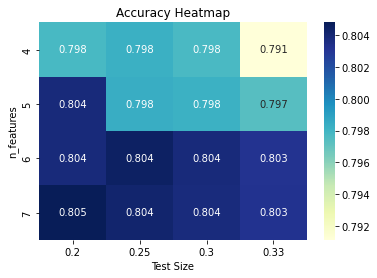

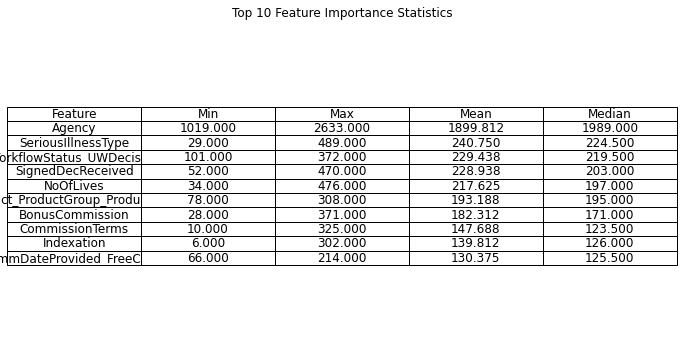

In [9]:
# Create empty lists to store results
results = []
feature_importances_dict = {}

# Iterate through each test size and n estimator value
for test_size in test_sizes:
    for n_estimators_value in n_estimators_values:
        # Split the data into training and testing sets with the current test size
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=test_size, random_state=42)

        # Train a LightGBM classifier
        lgb_classifier = lgb.LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
        lgb_classifier.fit(X_train, y_train)

        # Get feature importances
        feature_importances = pd.Series(lgb_classifier.feature_importances_, index=features).sort_values(ascending=False)

        # Store feature importances in dictionary for visualisation
        feature_importances_dict[(test_size, n_estimators_value)] = feature_importances
        
        # Select the top-n features based on importance
        for n in n_values:
            selected_features = feature_importances[:n].index.tolist()

            # Create a new dataset with the selected features
            selected_data = df[selected_features + [target]]

            # Train and evaluate the model with the current feature combination
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]

            lgb_classifier_selected = lgb.LGBMClassifier(n_estimators=n_estimators_value, random_state=42)
            lgb_classifier_selected.fit(X_train_selected, y_train)
            y_pred_selected = lgb_classifier_selected.predict(X_test_selected)

            accuracy = accuracy_score(y_test, y_pred_selected)
            results.append((test_size, n_estimators_value, n, accuracy))
            
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Test Size", "n_estimators", "n_features", "Accuracy"])

# Visualise Accuracy with Heatmap
heatmap_data = results_df.pivot_table(index="Test Size", columns="n_estimators", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

heatmap_data = results_df.pivot_table(index="n_features", columns="Test Size", values="Accuracy")
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Accuracy Heatmap")
plt.show()

feature_importance_stats = {}
for feature in features:
    feature_importance_stats[feature] = {
        'Min': min(importance[feature] for importance in feature_importances_dict.values()),
        'Max': max(importance[feature] for importance in feature_importances_dict.values()),
        'Mean': sum(importance[feature] for importance in feature_importances_dict.values()) / len(feature_importances_dict),
        'Median': pd.Series([importance[feature] for importance in feature_importances_dict.values()]).median()
    }
    
# Create a DataFrame from feature importance statistics
feature_importance_stats_df = pd.DataFrame(feature_importance_stats).T

# Sort features by Mean importance and select top 10
top_10_features = feature_importance_stats_df.sort_values(by='Mean', ascending=False).head(10)

# Define statistics and colors
statistics = ['Min', 'Max', 'Mean', 'Median']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a table of feature importance statistics
table_data = []
for feature, row in top_10_features.iterrows():
    row_values = [f"{row[stat]:.3f}" for stat in statistics]
    table_data.append([feature] + row_values)

table = ax.table(cellText=table_data, colLabels=['Feature'] + statistics, cellLoc='center', loc='center')


table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax.axis('off')
ax.set_title('Top 10 Feature Importance Statistics')

plt.show()

#### Class Aware Feature Importance

In [10]:
df = df.drop(columns=['PropDate'])

# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Calculate feature importance scores
feature_importance = rf_classifier.feature_importances_

# Calculate class-specific importance
class_labels = df['PolicyIssued'].unique()
class_importance = {}
for label in class_labels:
    mask = (y_train_resampled == label)
    class_importance[label] = feature_importance * mask.mean()
    
# Combine class-specific importance using weights based on class distribution
class_distribution = y_train_resampled.value_counts(normalize=True)
weighted_importance = sum(class_importance[label] * class_distribution[label] for label in class_labels)

# Print the weighted importance scores for each feature in descending order
importance_scores = [(feature_name, importance_score) for feature_name, importance_score in zip(X.columns, weighted_importance)]
importance_scores_sorted = sorted(importance_scores, key=lambda x: x[1], reverse=True)

for feature_name, importance_score in importance_scores_sorted:
    print(f"Feature: {feature_name}, Weighted Importance: {importance_score:.4f}")


Feature: Agency, Weighted Importance: 0.2074
Feature: WorkflowStatus_UWDecision, Weighted Importance: 0.1602
Feature: BonusCommissionPercentage, Weighted Importance: 0.0316
Feature: CommDateProvided_FreeCover, Weighted Importance: 0.0296
Feature: CommissionSacrificePercentage, Weighted Importance: 0.0291
Feature: Product_ProductGroup_ProductType, Weighted Importance: 0.0103
Feature: SignedDecReceived, Weighted Importance: 0.0077
Feature: NoOfLives, Weighted Importance: 0.0045
Feature: CommissionTerms, Weighted Importance: 0.0043
Feature: SeriousIllnessType, Weighted Importance: 0.0041
Feature: Indexation, Weighted Importance: 0.0039
Feature: CommissionSacrificeType_RenewalSacrificeType, Weighted Importance: 0.0028
Feature: BonusCommission, Weighted Importance: 0.0017
Feature: ComissionSacrifice, Weighted Importance: 0.0011
Feature: Discount, Weighted Importance: 0.0010
Feature: PaymentFreq, Weighted Importance: 0.0008


### Recursive Feature Elimination with Cross-Validation

#### Random Forest

In [11]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a RandomForestClassifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)


Selected features:
Agency
WorkflowStatus_UWDecision


#### GradientBoostingClassifier

In [12]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a GradientBoostingClassifier on the resampled data
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=gb_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)

Selected features:
Agency
NoOfLives
CommissionSacrificePercentage
CommissionTerms
BonusCommissionPercentage
SignedDecReceived
WorkflowStatus_UWDecision
Product_ProductGroup_ProductType
CommissionSacrificeType_RenewalSacrificeType
CommDateProvided_FreeCover


#### LightGBM

In [13]:
# Split data into features (X) and target (y)
X = df.drop(columns=['PolicyIssued'])
y = df['PolicyIssued']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Resampling with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train a LightGBM classifier on the resampled data
lgb_classifier = LGBMClassifier(random_state=42)
lgb_classifier.fit(X_train_resampled, y_train_resampled)

# Initialise RFECV with stratified folds
rfecv = RFECV(estimator=lgb_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV on the resampled data
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the selected feature indices
selected_feature_indices = rfecv.support_

# Get the selected feature names
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)

Selected features:
Agency
Indexation
NoOfLives
CommissionSacrificePercentage
CommissionTerms
BonusCommissionPercentage
SignedDecReceived
WorkflowStatus_UWDecision
Product_ProductGroup_ProductType
CommissionSacrificeType_RenewalSacrificeType
CommDateProvided_FreeCover


#### Cramer's V

Chi-square Test: Agency vs. Indexation
Chi2 Statistic: 12242567.33405635
P-value: 0.0

Chi-square Test: Agency vs. NoOfLives
Chi2 Statistic: 37873872.87931058
P-value: 0.0

Chi-square Test: Agency vs. PaymentFreq
Chi2 Statistic: 564923.6493841271
P-value: 0.0

Chi-square Test: Agency vs. ComissionSacrifice
Chi2 Statistic: 2852690.33249993
P-value: 0.0

Chi-square Test: Agency vs. CommissionSacrificePercentage
Chi2 Statistic: 389500284.2691703
P-value: 0.0

Chi-square Test: Agency vs. CommissionTerms
Chi2 Statistic: 4268979.562788421
P-value: 0.0

Chi-square Test: Agency vs. Discount
Chi2 Statistic: 51027.0634549038
P-value: 0.0

Chi-square Test: Agency vs. BonusCommission
Chi2 Statistic: 6799282.540648341
P-value: 0.0

Chi-square Test: Agency vs. BonusCommissionPercentage
Chi2 Statistic: 1095355853.7772186
P-value: 0.0

Chi-square Test: Agency vs. SeriousIllnessType
Chi2 Statistic: 18158127.333293006
P-value: 0.0

Chi-square Test: Agency vs. SignedDecReceived
Chi2 Statistic: 23191153.1

Chi-square Test: CommissionSacrificePercentage vs. Agency
Chi2 Statistic: 389500284.2691654
P-value: 0.0

Chi-square Test: CommissionSacrificePercentage vs. Indexation
Chi2 Statistic: 3927745.9020615784
P-value: 0.0

Chi-square Test: CommissionSacrificePercentage vs. NoOfLives
Chi2 Statistic: 16675487.680605652
P-value: 0.0

Chi-square Test: CommissionSacrificePercentage vs. PaymentFreq
Chi2 Statistic: 3215.346212364496
P-value: 1.0

Chi-square Test: CommissionSacrificePercentage vs. ComissionSacrifice
Chi2 Statistic: 581551.8591707277
P-value: 0.0

Chi-square Test: CommissionSacrificePercentage vs. CommissionTerms
Chi2 Statistic: 2556305.826244142
P-value: 0.0

Chi-square Test: CommissionSacrificePercentage vs. Discount
Chi2 Statistic: 21327.577989326215
P-value: 0.0

Chi-square Test: CommissionSacrificePercentage vs. BonusCommission
Chi2 Statistic: 1390847.318593493
P-value: 0.0

Chi-square Test: CommissionSacrificePercentage vs. BonusCommissionPercentage
Chi2 Statistic: 129803041.04

Chi-square Test: BonusCommissionPercentage vs. SignedDecReceived
Chi2 Statistic: 2948606.901546911
P-value: 0.0

Chi-square Test: BonusCommissionPercentage vs. WorkflowStatus_UWDecision
Chi2 Statistic: 73008603.05952743
P-value: 0.0

Chi-square Test: BonusCommissionPercentage vs. Product_ProductGroup_ProductType
Chi2 Statistic: 27291959.326007817
P-value: 0.0

Chi-square Test: BonusCommissionPercentage vs. CommissionSacrificeType_RenewalSacrificeType
Chi2 Statistic: 8745758.062263457
P-value: 0.0

Chi-square Test: BonusCommissionPercentage vs. CommDateProvided_FreeCover
Chi2 Statistic: 4914689.189812548
P-value: 0.0

Chi-square Test: BonusCommissionPercentage vs. PolicyIssued
Chi2 Statistic: 10388.285126161441
P-value: 3.1574152445500684e-76

Chi-square Test: SeriousIllnessType vs. Agency
Chi2 Statistic: 18158127.33329299
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. Indexation
Chi2 Statistic: 986506.7709072622
P-value: 0.0

Chi-square Test: SeriousIllnessType vs. NoOfLives
Chi

Chi2 Statistic: 2937570.085038433
P-value: 0.0

Chi-square Test: CommissionSacrificeType_RenewalSacrificeType vs. CommissionSacrificePercentage
Chi2 Statistic: 41295185.47151688
P-value: 0.0

Chi-square Test: CommissionSacrificeType_RenewalSacrificeType vs. CommissionTerms
Chi2 Statistic: 4059.389113727091
P-value: 1.0

Chi-square Test: CommissionSacrificeType_RenewalSacrificeType vs. Discount
Chi2 Statistic: 286.21002695530086
P-value: 0.41900432765271856

Chi-square Test: CommissionSacrificeType_RenewalSacrificeType vs. BonusCommission
Chi2 Statistic: 6815.4984475489355
P-value: 1.0

Chi-square Test: CommissionSacrificeType_RenewalSacrificeType vs. BonusCommissionPercentage
Chi2 Statistic: 8745758.062263457
P-value: 0.0

Chi-square Test: CommissionSacrificeType_RenewalSacrificeType vs. SeriousIllnessType
Chi2 Statistic: 1186433.1087414525
P-value: 0.0

Chi-square Test: CommissionSacrificeType_RenewalSacrificeType vs. SignedDecReceived
Chi2 Statistic: 797551.9189490003
P-value: 0.0

C

Indexation vs. WorkflowStatus_UWDecision
Cramer's V: 0.37527311264919977
Chi2 Statistic: 18643.87577038809
P-value: 0.0

Indexation vs. Product_ProductGroup_ProductType
Cramer's V: 0.61437821761305
Chi2 Statistic: 18643.87577038809
P-value: 0.0

Indexation vs. CommissionSacrificeType_RenewalSacrificeType
Cramer's V: 0.2037565727081826
Chi2 Statistic: 18643.87577038809
P-value: 0.0

Indexation vs. CommDateProvided_FreeCover
Cramer's V: 0.0
Chi2 Statistic: 18643.87577038809
P-value: 0.0

Indexation vs. PolicyIssued
Cramer's V: 0.046505774747384175
Chi2 Statistic: 18643.87577038809
P-value: 0.0

NoOfLives vs. Agency
Cramer's V: 0.7430956538158127
Chi2 Statistic: 18643.87577038809
P-value: 0.0

NoOfLives vs. Indexation
Cramer's V: 0.2637663980720615
Chi2 Statistic: 18643.87577038809
P-value: 0.0

NoOfLives vs. PaymentFreq
Cramer's V: 0.10819557532943355
Chi2 Statistic: 18643.87577038809
P-value: 0.0

NoOfLives vs. ComissionSacrifice
Cramer's V: 0.25761306210631013
Chi2 Statistic: 18643.875

CommissionTerms vs. Agency
Cramer's V: 0.7747633759695081
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionTerms vs. Indexation
Cramer's V: 0.0
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionTerms vs. NoOfLives
Cramer's V: 0.18577467262470707
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionTerms vs. PaymentFreq
Cramer's V: 0.05076095277950545
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionTerms vs. ComissionSacrifice
Cramer's V: 0.01073841125896142
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionTerms vs. CommissionSacrificePercentage
Cramer's V: 0.6464804752565355
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionTerms vs. Discount
Cramer's V: 0.03302651607073209
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionTerms vs. BonusCommission
Cramer's V: 0.0
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionTerms vs. BonusCommissionPercentage
Cramer's V: 0.37732551095360894
Chi2 Statistic: 18643.87577038809
P-value:

SeriousIllnessType vs. BonusCommissionPercentage
Cramer's V: 0.0
Chi2 Statistic: 18643.87577038809
P-value: 0.0

SeriousIllnessType vs. SignedDecReceived
Cramer's V: 0.1388554268279669
Chi2 Statistic: 18643.87577038809
P-value: 0.0

SeriousIllnessType vs. WorkflowStatus_UWDecision
Cramer's V: 0.3952105272389988
Chi2 Statistic: 18643.87577038809
P-value: 0.0

SeriousIllnessType vs. Product_ProductGroup_ProductType
Cramer's V: 0.6450002791210242
Chi2 Statistic: 18643.87577038809
P-value: 0.0

SeriousIllnessType vs. CommissionSacrificeType_RenewalSacrificeType
Cramer's V: 0.24324925181979914
Chi2 Statistic: 18643.87577038809
P-value: 0.0

SeriousIllnessType vs. CommDateProvided_FreeCover
Cramer's V: 0.0
Chi2 Statistic: 18643.87577038809
P-value: 0.0

SeriousIllnessType vs. PolicyIssued
Cramer's V: 0.020836415908120652
Chi2 Statistic: 18643.87577038809
P-value: 0.0

SignedDecReceived vs. Agency
Cramer's V: 0.7854222260431284
Chi2 Statistic: 18643.87577038809
P-value: 0.0

SignedDecReceived

CommissionSacrificeType_RenewalSacrificeType vs. BonusCommissionPercentage
Cramer's V: 0.3441785149034947
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionSacrificeType_RenewalSacrificeType vs. SeriousIllnessType
Cramer's V: 0.24324925181979914
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionSacrificeType_RenewalSacrificeType vs. SignedDecReceived
Cramer's V: 0.16096879913100268
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionSacrificeType_RenewalSacrificeType vs. WorkflowStatus_UWDecision
Cramer's V: 0.41739953087319553
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionSacrificeType_RenewalSacrificeType vs. Product_ProductGroup_ProductType
Cramer's V: 0.28844000760336597
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionSacrificeType_RenewalSacrificeType vs. CommDateProvided_FreeCover
Cramer's V: 0.10967121842038872
Chi2 Statistic: 18643.87577038809
P-value: 0.0

CommissionSacrificeType_RenewalSacrificeType vs. PolicyIssued
Cramer's V: 0.03

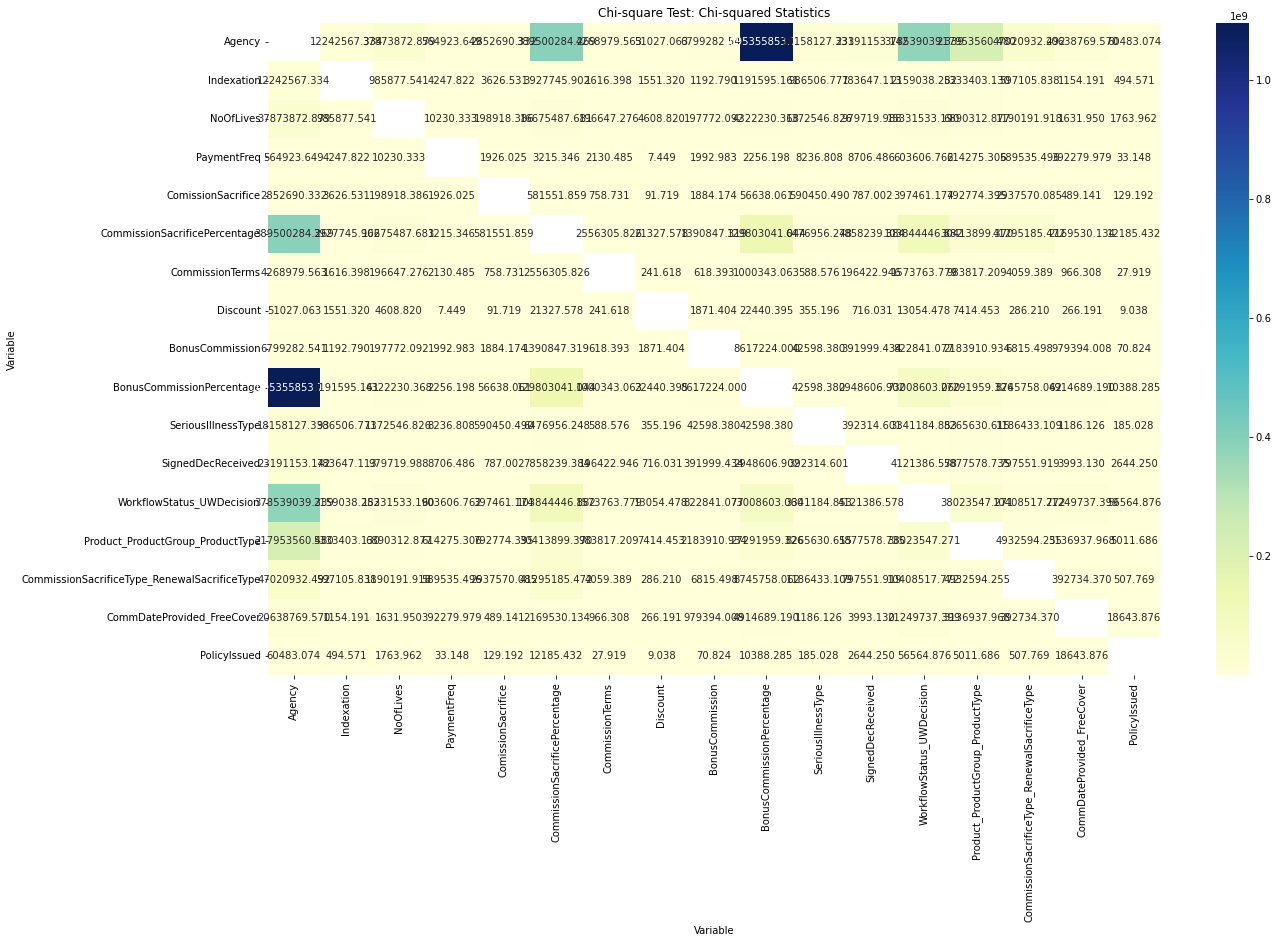

In [16]:
from scipy.stats import zscore
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import chi2_contingency

combined_data = np.hstack((X_train_resampled, y_train_resampled.values.reshape(-1, 1)))

# Convert combined_data to a DataFrame
train_data = pd.DataFrame(combined_data, columns=list(X_train.columns) + ['PolicyIssued'])

# Perform chi-square test for each pair of categorical variables
for column1 in train_data.select_dtypes(include='float64'):
    for column2 in train_data.select_dtypes(include='float64'):
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            print(f"Chi-square Test: {column1} vs. {column2}")
            print(f"Chi2 Statistic: {chi2}")
            print(f"P-value: {p_value}")
            print()
            
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = np.sum(confusion_matrix)
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corrected = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corrected = r - ((r - 1) ** 2) / (n - 1)
    k_corrected = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corrected / min((k_corrected - 1), (r_corrected - 1)))

# Calculate Cramer's V for variables
for column1 in train_data:
    for column2 in train_data:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            v = cramers_v(contingency_table.values)
            print(f"{column1} vs. {column2}")
            print(f"Cramer's V: {v}")
            print(f"Chi2 Statistic: {chi2}")
            print(f"P-value: {p_value}")
            print()
            
# Create an empty dataframe to store Chi-squared statistics
chi2_stats_df = pd.DataFrame(index=train_data.select_dtypes(include='float64').columns, columns=train_data.select_dtypes(include='float64').columns)

# Perform chi-square test for each pair of categorical variables
for column1 in train_data:
    for column2 in train_data:
        if column1 != column2:
            contingency_table = pd.crosstab(train_data[column1], train_data[column2])
            chi2_stat, _, _, _ = chi2_contingency(contingency_table)
            chi2_stats_df.loc[column1, column2] = chi2_stat

# Create a heatmap of the Chi-squared statistics
plt.figure(figsize=(20, 12))
sns.heatmap(chi2_stats_df.astype(float), annot=True, fmt=".3f", cmap='YlGnBu')
plt.xlabel('Variable')
plt.ylabel('Variable')
plt.title('Chi-square Test: Chi-squared Statistics')
plt.show()

Based on the Cramer's V and p-values, the features that are highly correlated with PolicyIssued and are likely to be important predictors are:

Agency:
Cramer's V = 0.361

WorkflowStatus_UWDecision:
Cramer's V = 0.5238

CommDateProvided_FreeCover:
Cramer's V = 0.3073

Product_ProductGroup_ProductType:
Cramer's V = 0.1391

SignedDecReceived:
Cramer's V = 0.1129

BonusCommissionPercentage:
Cramer's V = 0.1139

CommissionSacrificePercentage:
Cramer's V = 0.118

Agency and WorkflowStatus_UWDecision, and CommDateProvided_FreeCover occur in the majority of the analyses, implying that they are the most essential variables for predicting the conversion of life assurance apps. Product_ProductGroup_ProductType, SignedDecReceived, BonusCommissionPercentage, and CommissionSacrificePercentage might also be considered because they occur consistently in various techniques. These features might serve as a solid starting point for developing a predictive model.